# Исследование онлайн магазина компьютерных игр

Исследование проводилось на открытых данных интернет-магазина компьютерных игр "Стримчик", в которых отображены данные за 1980-2016гг. 
 
<b>Цель исследования </b> — выявить критерии, которые влияют на успешность игры для того, чтобы спланировать рекламные компании на 2017г.

В ходе исследования будет изучаться вопрос о наличии зависимости между отзывами критиков и пользователей и количеством продаж, будет составлен портрет пользователя каждого региона по его предпочтениям в жанрах и видах приставок. 

Также будут проверены две гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.
    
Таким образом, исследование пройдёт в несколько этапов:

- Обзор данных.
- Предобработка данных.
- Исследовательский анализ данных.
- Составление портрета пользователя каждого региона. 
- Проверка гипотез.
- Выводы.

# Общее представление о данных

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import statsmodels

In [177]:
df = pd.read_csv('/Users/alena/Desktop/ЯП/jupyter notebook/final_project/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [178]:
# Создаю функцию для описания данных
def description(x):
    print('\033[1m' + 'Получение общей информации о данных в таблице:' + '\033[0m')
    display(x.info())
    print('\033[1m' + 'Наличие дубликатов в таблице:' + '\033[0m')
    display(x.duplicated().sum())

In [179]:
description(df)

Получение общей информации о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

Наличие дубликатов в таблице:


0

Количество ненулевых объектов в строках не совпадает, присутствуют пропущенные значения. Явные дубликаты отсутствуют. 

# Предобработка данных

## Переименование столбцов

In [180]:
# Привожу названия колонок к общепринятому стилю
df.columns = df.columns.str.lower()

## Выявление и обработка пропусков

In [181]:
# Подсчитываю долю пропущенных значений
pd.DataFrame(round(df.isna().mean()*100,1))

,0
name,0.0
platform,0.0
year_of_release,1.6
genre,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0
other_sales,0.0
critic_score,51.3
user_score,40.1


Определяется большая доля пропущенных значений в столбцах с оценкой критиков, пользователей и рейтингом игр, пока оставим их. В столбце с годом релиза пропущено 269 значений (1,6% от всех данных), их восстановить достаточно проблематично, позволю себе удалить данные пропуски, общая доля пропусков менее 5%.

In [182]:
df.loc[df['genre'].isna()] # фильтруем строки, в которых пропущены жанры

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки можно удалить, так как они не содержат практически никакой полезной информации. 

In [183]:
df.dropna(subset=['genre', 'year_of_release'], axis='index', inplace=True) 
# удалим пропущенные значения в столбцах с указанием жанра и года релиза игры

In [184]:
df.isna().sum() #проверяем, все ли удалилось

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Остальные пропуски присутствуют в столбцах с рейтингом и оценкой критиков и пользователей, их изучим после

## Изменение типов данных

In [185]:
df['year_of_release'] = df['year_of_release'].astype('Int64') 
# преобразуем тип данных на целочисленный в столбце с годом релиза

Среди оценок пользователей присутсвуют значение tbd = to_be_decided, вероятно, пользователь еще не определился с оценкой и поставит ее всполедствии, когда опробует новую игру. Значения можно заменить на заглушку или провести в NaN, тк никакой информации о рейтинге они не несут.
Пропуски в столбцах с рейтингом заменять на медианные значения/нули нельзя, иначе это исказит выборку, оценка будет неправдивая. 

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


In [187]:
df.loc[df['user_score'] == 'tbd','user_score'] = np.nan # заменим значения 'tbd' на NaN  

## Поиск неявных дубликатов

In [188]:
df.genre.sort_values().unique() # Запрос отсортированных по алфавиту уникальных значений в столбце с жанрами 

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

In [189]:
df.rating.sort_values().unique() # Запрос отсортированных по алфавиту уникальных значений в столбце с рейтингом 

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Существует общепризнанный рейтинг игр на сайте ESRB в зависимости от возрастных ограничений:
- AO adults only 18+
- E everyone
- E ages 10+ 
- EC ages 3+ 
- K-A kids and adult (позже перееименован в E everyone), можно объединить эти строки
- T teen ages 13+
- M mature 17+
- PR rating pending (игра еще не вышла в релиз, пока на этапе рекламы, маркетинга)

Согласно обновленной классификации можно объединить строки с категорией К-А с категорией Е 

In [190]:
df.replace('K-A', 'E', inplace=True) # заменим значения К-А на Е по новой классификации

In [191]:
# Поставим заглушку на пропущенные значения в столбцах с оценками и рейтингом игр
df['user_score'] = df['user_score'].fillna('nondefind')
df['rating'] = df['rating'].fillna('nondefind')
df['critic_score'] = df['critic_score'].fillna('nondefind')

In [192]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nondefind,nondefind,nondefind
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nondefind,nondefind,nondefind


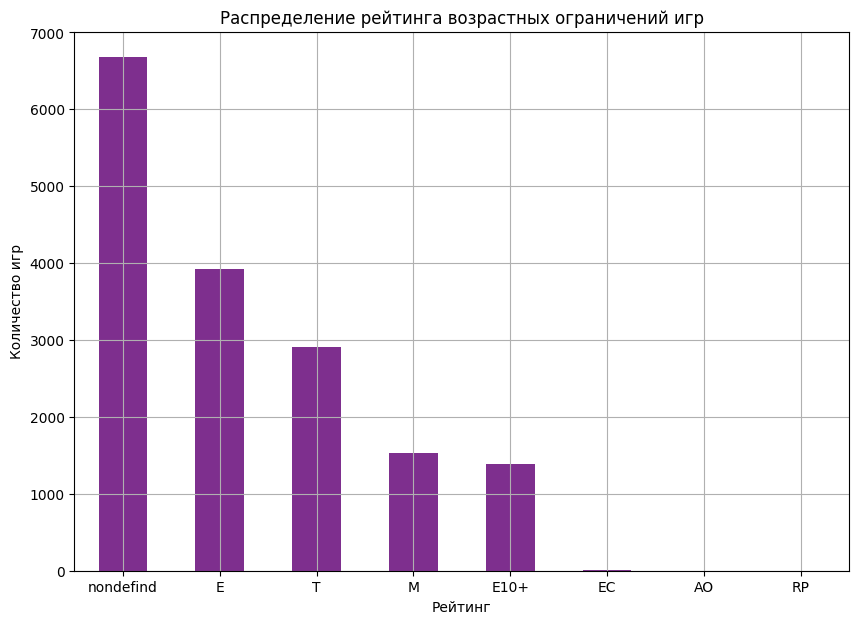

In [193]:
plt.figure(figsize=(10, 7))
plt.title('Распределение рейтинга возрастных ограничений игр')
# сгруппируем игры по количеству в зависимости от их возрастных ограничений
(df
    .groupby('rating')['platform'].count().sort_values(ascending=False)
    .plot(kind='bar', color="#7E2F8E", rot=360, grid=True)
)
plt.ylabel('Количество игр')
plt.xlabel('Рейтинг'); 

По графику видно распределение количества игр по различным возрастным ограничениям, в категории AO adults only 18+ присутсвует только 1 игра, среди не определенных RP и игр для совсем маленьких - EC также небольшое количество игр. В основном распределение игр идет по категориям для каждого E everyone и для подростков T, что похоже на правду. И определяется большая часть игр,где рейтинг отсутствует.

In [194]:
len(df.query('year_of_release < 1995')['rating']) # определим количество строк с годом релиза до 1995г 

486

In [195]:
df.query('year_of_release < 1995')['rating'].unique()

array(['nondefind', 'T', 'M', 'E10+'], dtype=object)

Расчитаю общую сумму продаж по врем регионам:

In [196]:
df['sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
# сложим значения продаж в Америке, Европе и Японии и другие

<b>Выводы по предобработке данных: </b>
- Пропуски имеются в столбце с годом релиза игры (269 строк, что составляет 1,6% всего датасета), которые возможно возникли по причине того, что их просто забыли ввести и в виду того, что они занимают небольшой процент от общей выборки было принято решение избавиться от этих строк. Также 2 пропуска было в столбцах с жанром и названием игр, которые могли возникнуть случайно и были удалены из датасета.
- Большое количество пропусков имеется в столбцах с рейтингом по возрастным ограничениям - 6766 строк, в столбцах с оценкой пользователя и критика, которые были заменены на заглушки.  
- В столбце в оценкой пользователя были значения tbd (to be desided) - соответсвуют тому, что пользователь еще не определился с оценкой и поставит ее позже, эти значения были заменены на NaN, потому что информации об оценке они не несут. 

# Исследовательский анализ данных

## Исследование количества игр по годам

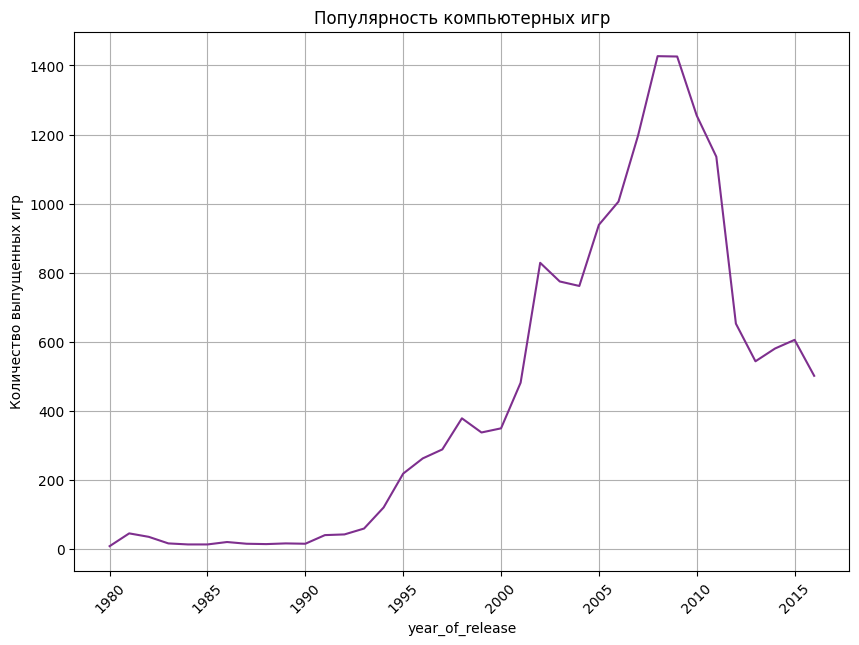

In [204]:
(df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count') 
 # сводная таблица по общему количеству выпущенных игр в разные года
     .plot(style='-', rot=45, color="#7E2F8E", grid=True, figsize=(10, 7), legend=False), 
 plt.ylabel('Количество выпущенных игр'),
 plt.title('Популярность компьютерных игр'));

По графику определяется явный пик по количеству вышедших игр в год, начиная с 1999 по 2007 виден достаточно резкий рост, с 2008г - определяется достаточно резкое падение. Наибольшее количество выпущенных игр определяется в период с 2004 по 2009гг. 
Вероятно, такой пик связан с тем, что в 2000-х компьютерные игры резко набирали популярность в связи с появлением первых приставок, продолжая до 2008 было увеличение количества игр, после падение может быть связано с тем, что создатели игр поменяли тактику и постепенно переходили от количества к качеству, требования к качеству картинки, звуку, функционалу, наполненности игры стали расти и выпуск начал занимать большее количество времени, в связи с тем количество новых выпущенных игр стало уменьшаться. 

## Исследование продаж по платформам

In [198]:
df.platform.sort_values().unique() # исследуем названия платформ

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

In [200]:
popul_platform = df.groupby('platform')['sales'].sum().sort_values(ascending=False).reset_index()
popul_platform.head(10)

,platform,sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


По графику выявляются топ платформ с наибольшими суммарными продажами за весь период (40 лет) по возрастающей. Для выбора ТОП платформ буду использовать квантиль, те платформы, чьи продажи превышают 0.75 квантиль являются наиболее популярными. 

In [201]:
q = popul_platform.reset_index()['sales'].quantile(0.75)
popul_platform = popul_platform[popul_platform['sales'] > q]
popul_platform_name = list(popul_platform['platform'])
popul_platform_name # список с популярными платформами

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA']

## Рассмотрим популярные приставки в разрезе временного промежутка

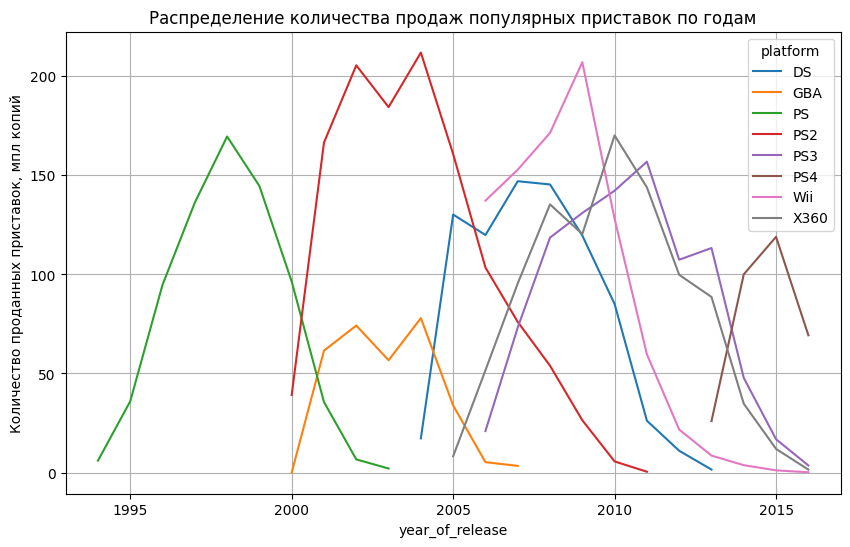

In [202]:
(df.query('platform in @popul_platform_name')
    .pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum') 
    .plot(figsize=(10,6), xlim=(1993,2017), grid=True), 
 plt.ylabel('Количество проданных приставок, мпл копий'),
 plt.title('Распределение количества продаж популярных приставок по годам'));
# построим график по сводной таблице, в которой показано распределение количества продаж популярных приставок по годам 

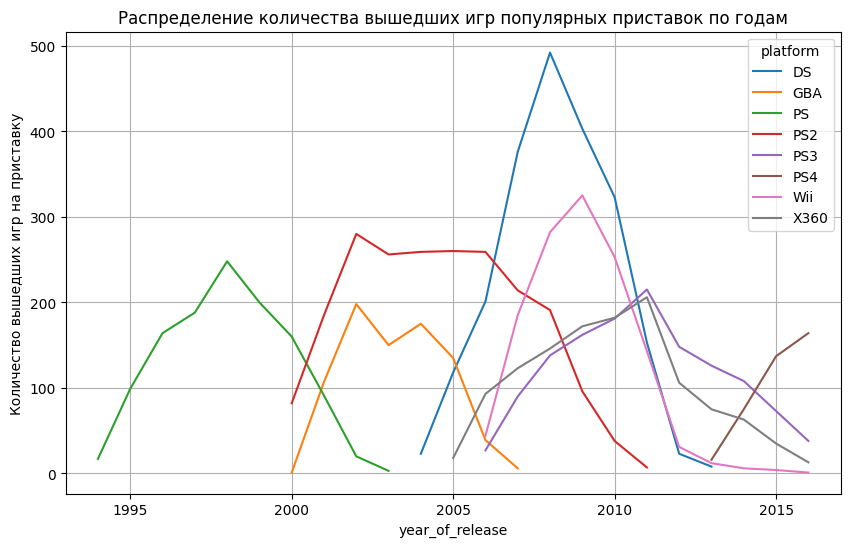

In [203]:
popul_platform = ['PS', 'DS', 'PS3', 'Wii', 'X360', 'PS2', 'PS4', 'XOne'] # составим список с популярными платформами
(df.query('platform in @popul_platform_name')
    .pivot_table(index='year_of_release', columns='platform', values='name', aggfunc='count') 
    .plot(figsize=(10,6), xlim=(1993,2017), grid=True), 
 plt.ylabel('Количество вышедших игр на приставку'),
 plt.title('Распределение количества вышедших игр популярных приставок по годам'));
# построим график по сводной таблице, в которой показано распределение количества вышедших игр популярных приставок по годам 

Потенциально прибыльной выглядит приставка PS4, тк ее жизненный цикл только начался и ее продажи будут расти. 

Проанализировав наиболее популярные приставки по годам определяется тренд на определенные приставки: 
- на игры, выпускаемые для PS2, был пик протаж в 2002г и постепенный спад до 2010г до выхода следующего поколения приставки PS3
- на игры, выпускаемые для PS3 (игровая приставка фирмы Sony), был пик протаж в 2011г и постепенный спад к 2016г.
- на игры, выпускаемые для Wii (игровая приставка фирмы Nintendo), был пик протаж в 2009г и спад к 2012г.
- на игры, выпускаемые для X360 (игровая приставка компания Microsoft), был пик протаж в 2011г и спад к 2016г. 

У приставок  в целом просматривается срок жизни в 10 лет, который охватывает появление, пик продаж и их спад в связи с появлением новых поколений, в течение первых 5 лет после выхода приставки идет рост продаж с явным пиком, далее спад, который связан с выходом следующих поколений (в 2013г - выход PS4, в 2010г X-box S). 
У японских приставок Wii график немного смещен влево, пик приходится на 2009г и спад к 2012г в связи с выходом новой консоли Nintendo 3DS в 2011г. По поводу Nintendo - их популярность связана с более бюджетной ценой по сравнению с Xbox, PS, поэтому в кризис 2008г она стала такой покупаемой, этим объясняется резкий пик. У приставки DS Nintendo также виден 10 летний срок жизни (с 2004 по 2014гг). 
    
Выход новых платформ происходит у разных компаний примерно в один период: 
- 2000-2001 (выход X360, PS2)
- 2005-2006 (PS3, X360, Wii)
- 2013 (XOne, PS4)
    
После выхода следующей серии предыдущая еще 2-3 года остается популярной и игры на нее продолжают покупать.         

## Актуальный период 2013-2016гг

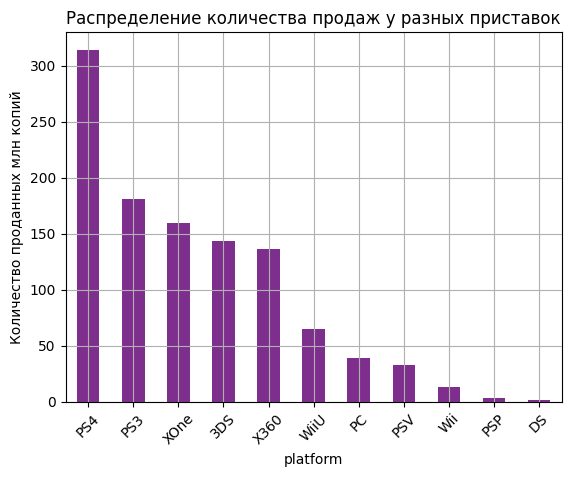

In [206]:
(df[df['year_of_release'] > 2012]
    .groupby('platform')['sales'].agg('sum').sort_values(ascending=False)
    .plot(kind='bar', rot=45, color="#7E2F8E", grid=True), 
 plt.title('Распределение количества продаж у разных приставок'),
 plt.ylabel('Количество проданных млн копий')
    );

Из данного графика определяются лидирующие по продажам платформы за актуальный период 2013 - 2016гг - это PS4, PS3, XOne, 3DS, X360. Наименьшее количество продаж отмечается у DS (на ее место пришло следующее поколение 3DS), Wii (на ее место пришло следующее поколение WiiU)

In [29]:
df_actual = df.query('year_of_release > 2012') # отфильтруем данные за актуальный период
popul_platform_act = ['PS4', 'PS3', 'XOne', '3DS', 'X360'] # создадим список популярных платформ за актуальный период

Отфильтруем данные за актуальный период с 2013 по 2016гг, по которому можно спрогнозировать показатели 2017г. Данный период не имеет пиков продаж, характеризуется постепенным общим спадом продаж для всех платформ и будет актуальным для прогнозирования. Оценивать больший промежуток не имеет смысла, так как область компьютерных игр достаточно динамична, а меньший промежуток также брать нецелесообразно, потому что нужно хотя бы три года, чтобы определить тренд продаж и составить прогнозы, учитывая, что данные за 2016г не полные. 

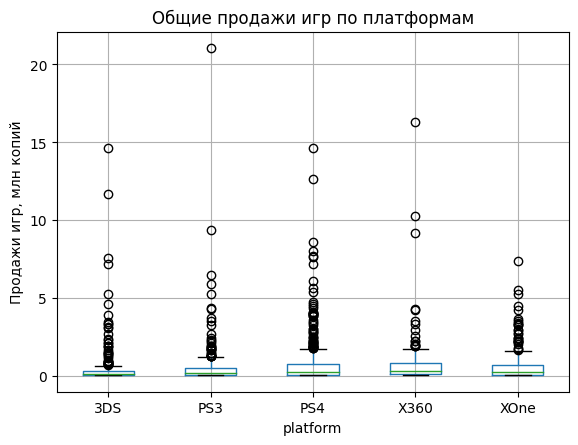

In [30]:
(df_actual.query("platform in @popul_platform_act")
    .boxplot(column='sales', by='platform'), 
 plt.ylabel('Продажи игр, млн копий'),
 plt.title('Общие продажи игр по платформам'), 
 plt.suptitle(''));

По графикам рапределения определяется большое количество выбросов и смещение графиков вправо, при этом средние значения расположены около нуля, это говорит о том, что есть какое-то количество более успешных игр, которые окупают бюджет компании, а большинство игр продается не в таком количестве. Для избежания влияния выбросов далее необходимо применять медианные значения продаж.

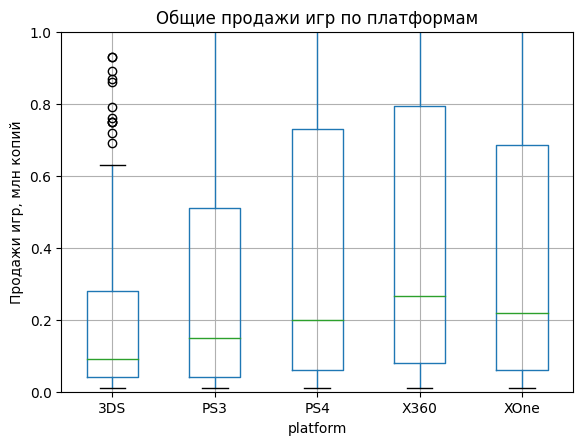

In [31]:
(df_actual.query("platform in @popul_platform_act")
    .boxplot(column='sales', by='platform'), 
 plt.ylim(ymin=0, ymax=1),
 plt.ylabel('Продажи игр, млн копий'),
 plt.title('Общие продажи игр по платформам'), 
 plt.suptitle(''));

При более детальном рассмотрении графиков распределения для актуальных платформ межквартильный интервал, содержищий 50% выборки, находится в диапазоне:
- 3DS от 40 до 280 тыс копий, среднее - 90 тыс копий, max - 14.6 млн
- PS3 от 40 до 510 тыс копий, среднее - 150 тыс копий, max - 21.05 млн
- XOne от 60 до 685 тыс копий, среднее - 220 тыс копий, max - 7.4 млн
- PS4 от 60 до 730 тыс копий, среднее - 200 тыс копий, max - 14.3 млн
- X360 от 80 до 795 тыс копий, среднее - 265 тыс копий, max - 16.3 млн

## Влияние отзывов критиков и пользователей на продажи

In [32]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nondefind,nondefind,nondefind,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nondefind,nondefind,nondefind,31.38


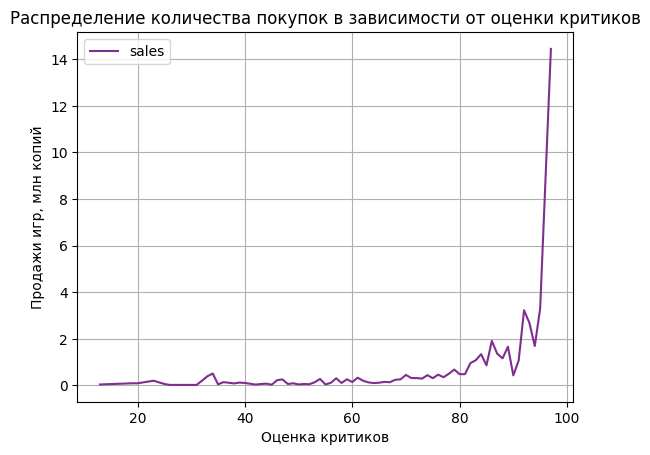

In [207]:
(df_actual.query('platform in @popul_platform_act')
    .pivot_table(values='sales', index='critic_score', aggfunc='median')
    .plot(grid=True,  color="#7E2F8E", xlabel='Оценка критиков', ylabel='Продажи игр, млн копий'), 
 plt.title('Распределение количества покупок в зависимости от оценки критиков'));

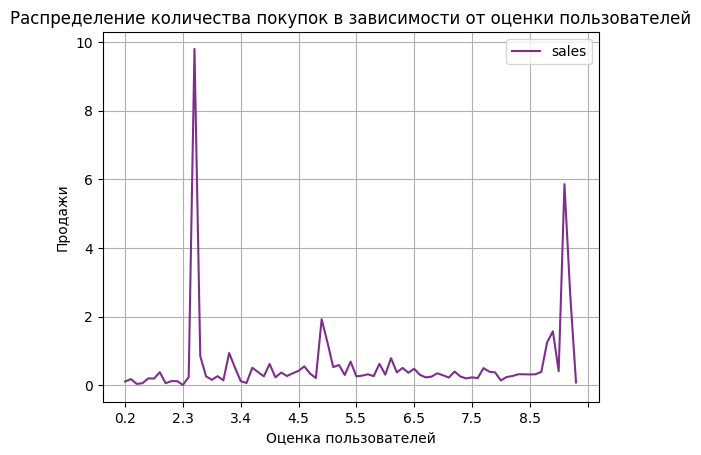

In [34]:
(df_actual.query('platform in @popul_platform_act')
    .pivot_table(values='sales', index='user_score', aggfunc='median')
    .plot(grid=True,  color="#7E2F8E", xlabel='Оценка пользователей', ylabel='Продажи'), 
 plt.title('Распределение количества покупок в зависимости от оценки пользователей'));

Выявлен явный пик среди количества продаж у платформ с рейтингом критиков выше 87, с рейтингом пользователей ситуация неоднозначная, при рассмотрении влияния отзывов пользователей для всех популярных платформ на медианные значения продаж отмечается явный пик при оценке пользователей в 2.3 балла. В оценке критиков ситуация более однозначная, с ростом рейтинга увеличиваются и продажи. 

In [35]:
df_actual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   Int64  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     2233 non-null   object 
 9   user_score       2233 non-null   object 
 10  rating           2233 non-null   object 
 11  sales            2233 non-null   float64
dtypes: Int64(1), float64(5), object(6)
memory usage: 229.0+ KB


In [212]:
pd.set_option('mode.chained_assignment','raise')

# заменю значения 'nondefind' на пропуски, чтобы сделать корреляционные тесты
df_actual['critic_score'] = df_actual['critic_score'].replace('nondefind', np.nan)
df_actual['user_score'] = df_actual['critic_score'].replace('nondefind', np.nan)
df_actual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   Int64  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     991 non-null    float64
 9   user_score       991 non-null    float64
 10  rating           2233 non-null   object 
 11  sales            2233 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 229.0+ KB


## Корреляция между оценками и продажами

In [224]:
# создам функцию для графиков разброса
def scatter(x1,x2,y):
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(211)
    ax1.scatter(x1, y)
    ax1.set_title('Зависимость продаж от оценки критиков', size=20)
    ax1.set_ylabel('Продажи в млн. копий', size=15)
    ax1.grid(True)

    ax2 = fig.add_subplot(212)
    ax2.scatter(x2, y)
    ax2.set_title('Зависимость продаж от оценки игроков', size=20)
    ax2.set_ylabel('Продажи в млн. копий', size=15)
    ax2.grid(True)

    plt.tight_layout(h_pad = 2)
    plt.show()

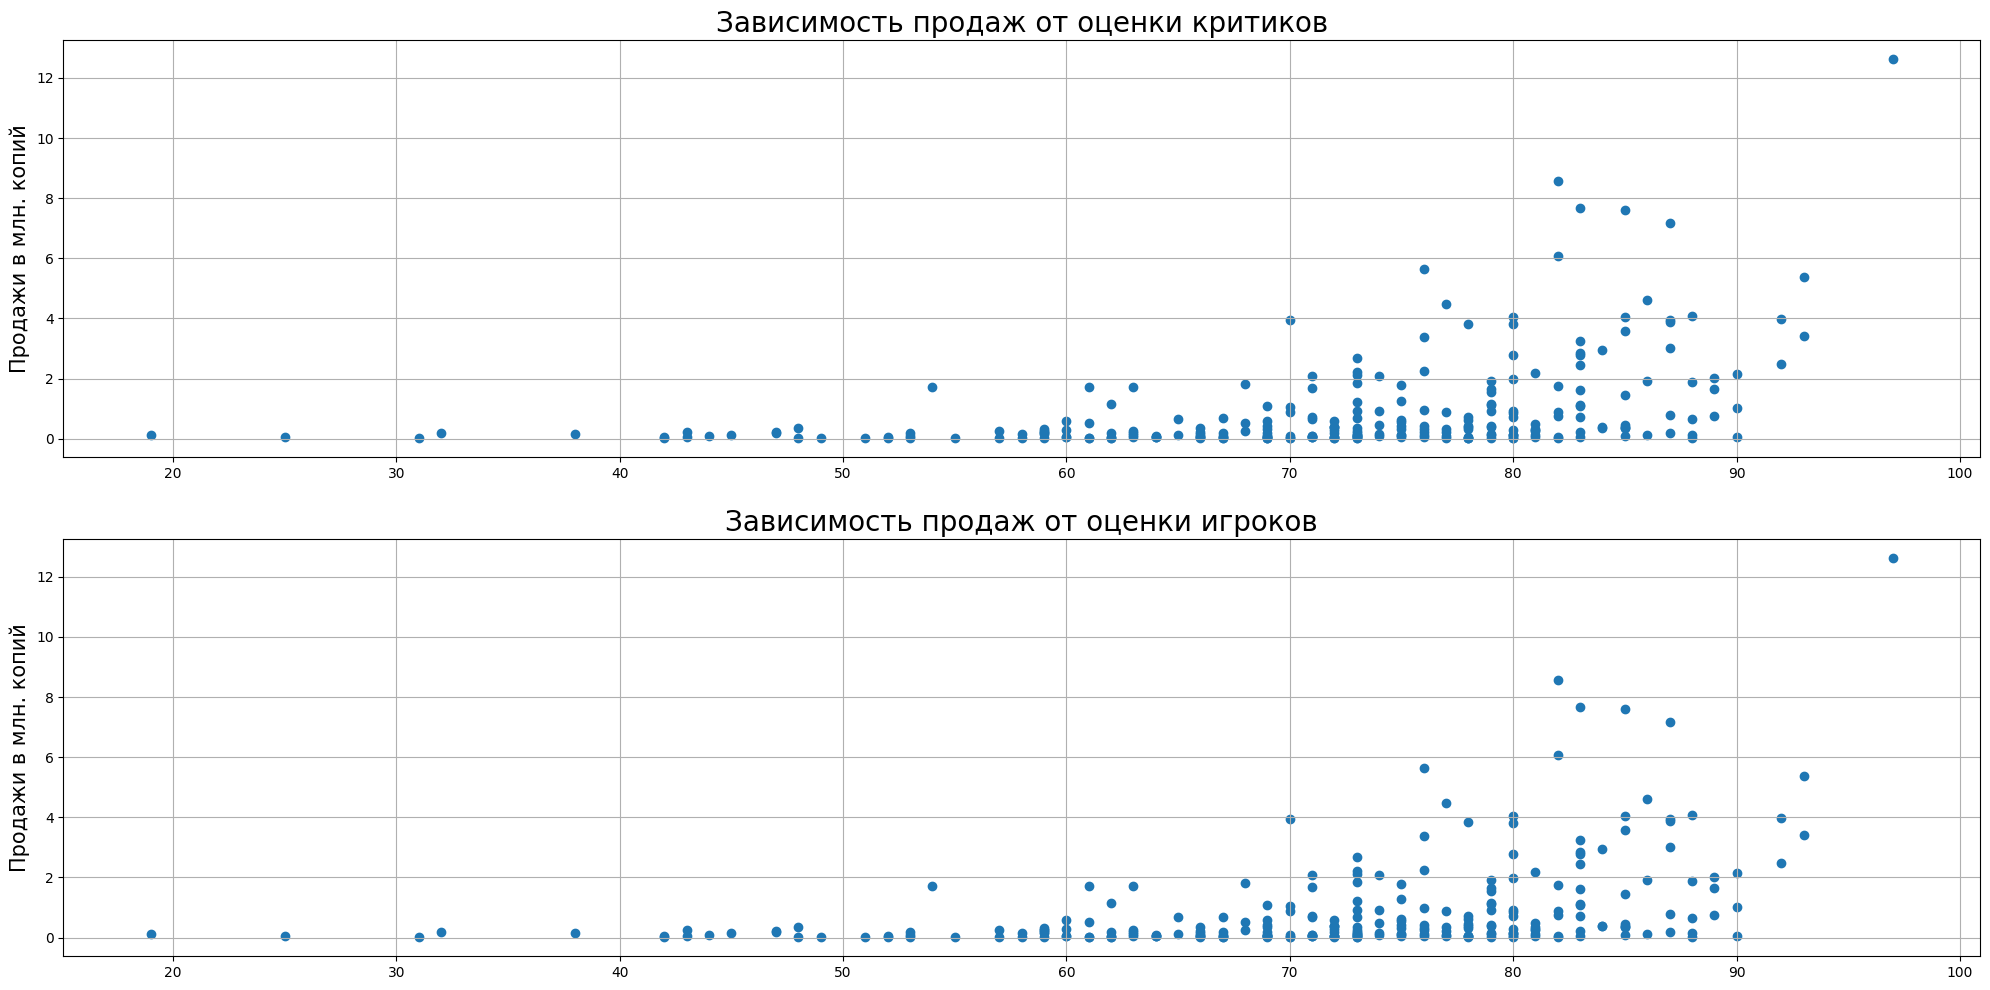

In [225]:
# отфильтрую данные по наиболее перспективной платформе
ps4 = df_actual.query('platform == "PS4"').copy()
x1 = ps4['critic_score']
x2 = ps4['user_score']
y = ps4['sales']

scatter(x1,x2,y)

По графикам взаимосвязи корреляция между оценками критиков и пользователей и общими продажами слабо положительная.

In [39]:
# смотрю коэффициенты корреляции
(df_actual.query("platform in @popul_platform_act")
    .groupby('platform')[['sales', 'critic_score', 'user_score']].corr())

sales  critic_score  user_score
platform                                                 
3DS      sales         1.000000      0.357057    0.357057
         critic_score  0.357057      1.000000    1.000000
         user_score    0.357057      1.000000    1.000000
PS3      sales         1.000000      0.334285    0.334285
         critic_score  0.334285      1.000000    1.000000
         user_score    0.334285      1.000000    1.000000
PS4      sales         1.000000      0.406568    0.406568
         critic_score  0.406568      1.000000    1.000000
         user_score    0.406568      1.000000    1.000000
X360     sales         1.000000      0.350345    0.350345
         critic_score  0.350345      1.000000    1.000000
         user_score    0.350345      1.000000    1.000000
XOne     sales         1.000000      0.416998    0.416998
         critic_score  0.416998      1.000000    1.000000
         user_score    0.416998      1.000000    1.000000

Получены коэффициенты корреляции для параметров с продажами и оценками критиков и пользователей для популярный платформ: 
- в общем между продажами и оценкой пользователей для всех популярных платформ коэффициент низкий, у некоторых даже отрицательный, то есть корреляции не наблюдается
- между продажами и оценкой критиков коэффициент средний около 0.4 для приставок PS4, XOna

## Распределение игр по жанрам

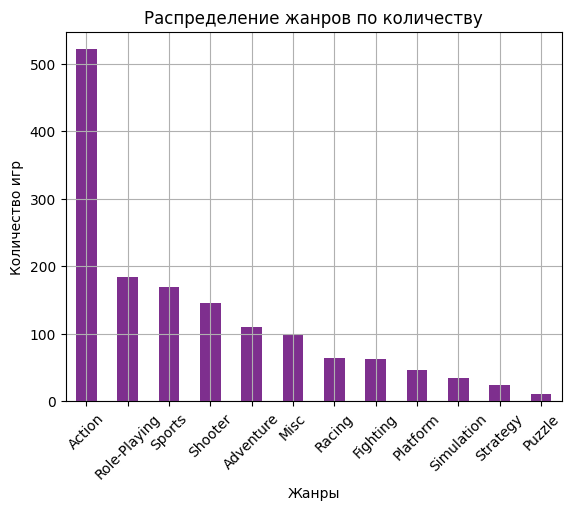

In [40]:
(df_actual.query("platform in @popul_platform_act")
    .groupby('genre')['platform'].count().sort_values(ascending=False)
    .plot(kind='bar', rot=45, color="#7E2F8E", xlabel='Жанры', ylabel='Количество игр', grid=True), 
 plt.title('Распределение жанров по количеству'));

Выявляются наиболее популярные жанры игр: боевики, ролевые игры и спортивные. Но общие продажи - плохая метрика для поиска наиболее прибыльного жанра. За высокими показателями общих продаж может скрываться множество мелких игр с низкими продажами или низкий рейтинг и много провалов. Лучше найти жанр, где игры стабильно приносят высокий доход - для этого стоит рассмотреть средние или медианные продажи.

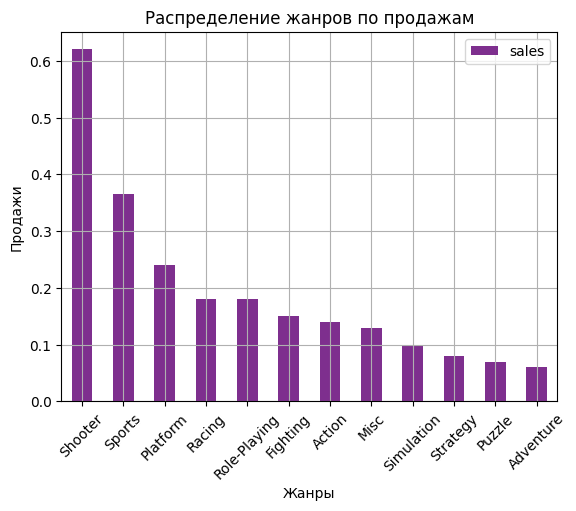

In [41]:
(df_actual.query("platform in @popul_platform_act")
    .pivot_table(index='genre', values='sales', aggfunc='median').sort_values('sales', ascending=False)
    .plot(kind='bar', rot=45, color="#7E2F8E", xlabel='Жанры', ylabel='Продажи', grid=True), 
 plt.title('Распределение жанров по продажам')); # построим графики по сводной таблице распределения медианных значений продаж разных жанров

Наиболее прибыльными жанрами являются жанры - шутеры, спортивные игры, платформеры. Менее прибыльные - приключенческие игры, стратегии, пазлы.

## Портрет пользователя каждого региона

### Распространенность приставок по регионам

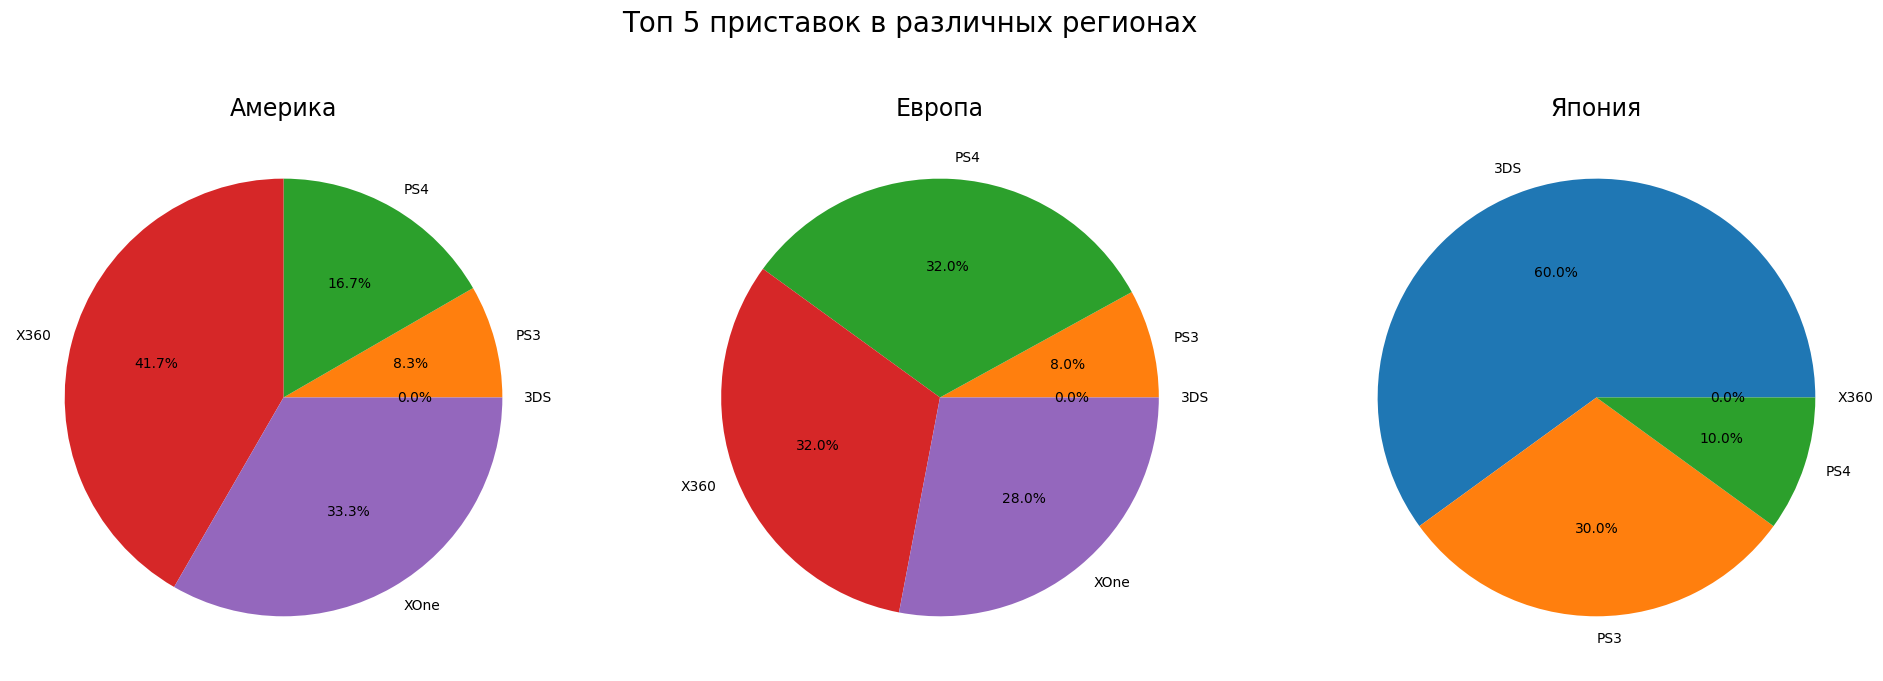

In [230]:
df_genre = (df_actual.query("platform in @popul_platform_act")
    .pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='median').reset_index())
# создадим сводную таблицу по платформам в зависимости от медианных значений продаж в каждом регионе              
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8)) # построим 3 графика по сводной таблице
ax1.pie(x='na_sales', labels='platform', data=df_genre.head(5), autopct='%1.1f%%', normalize=True)
ax2.pie(x='eu_sales', labels='platform', data=df_genre.head(5), autopct='%1.1f%%', normalize=True)
ax3.pie(x='jp_sales', labels='platform', data=df_genre.head(4), autopct='%1.1f%%', normalize=True)
plt.suptitle('Топ 5 приставок в различных регионах', size=20)
ax1.set_title('Америка', size=17) # зададим название графика
ax2.set_title('Европа', size=17) # зададим название графика
ax3.set_title('Япония', size=17); # зададим название графика

Топ 5 приставок отличается в зависимости от стран:
- В Америке это по убыванию: X360, XOne, PS4, PS3, 3DS
- В Европе: X360, PS4, XOne, PS3, 3DS
- В Японии: 3DS, PS3, PS4
    
Различие связано с ценой, рекламной компанией, маркетингом и многими факторами. Nintendo является более бюджетным и доступным вариантом игровых приставок, также она портативна и мобильна, что нравится игрокам из Японии (они предпочитают играть в транспорте), поэтому она так популярна у них (3DS). Популярность приставок в Америке и Европе примерно схожа, за некоторыми исключениями. PS и Xbox в целом два больших конкурента и поэтому находятся на первых местах. 

### Распространенность жанров по регионам

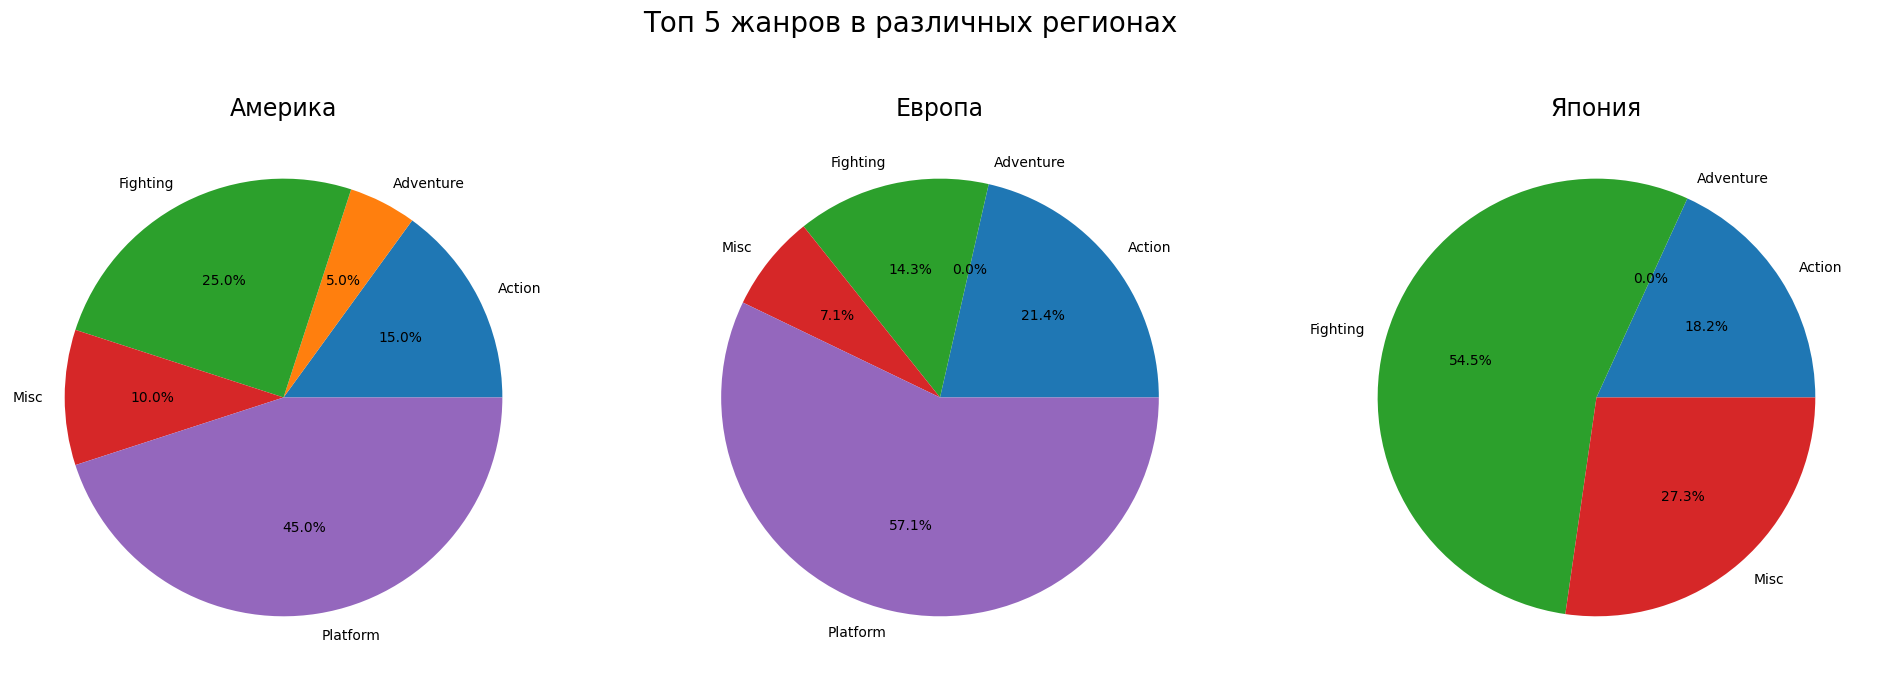

In [231]:
df_genre = (df_actual.query("platform in @popul_platform_act")
    .pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='median').reset_index())
#df_actual
df_genre
# создадим сводную таблицу по жанрам в зависимости от медианных значений продаж в каждом регионе                
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))  # построим 3 графика по сводной таблице
ax1.pie(x='na_sales', labels='genre', data=df_genre.head(5), autopct='%1.1f%%', normalize=True)
ax2.pie(x='eu_sales', labels='genre', data=df_genre.head(5), autopct='%1.1f%%', normalize=True)
ax3.pie(x='jp_sales', labels='genre', data=df_genre.head(4), autopct='%1.1f%%', normalize=True)
plt.suptitle('Топ 5 жанров в различных регионах', size=20)
ax1.set_title('Америка', size=17) # зададим название графика
ax2.set_title('Европа', size=17) # зададим название графика
ax3.set_title('Япония', size=17); # зададим название графика

В зависимости от регионов популярность жанров различна. Топ 5 жанров: 
- В Америке: platform, fighting, action, misc, adventure
- В Европе: platform, action, fighting,  misc, adventure
- В Японии: fighting, misc, action
    
    Америка и Европа схожи по предпочтениям, в то время как Япония достаточно самобытна. Топ жанров определяли по медианным значениям продаж в каждом регионе, потому что на медиану выбросы не влияют (продажи имеют большое количество выбросов судя по графикам распределения за счет некоторых экслюзивных игр, которые продаются больше, чем основная часть игр). 

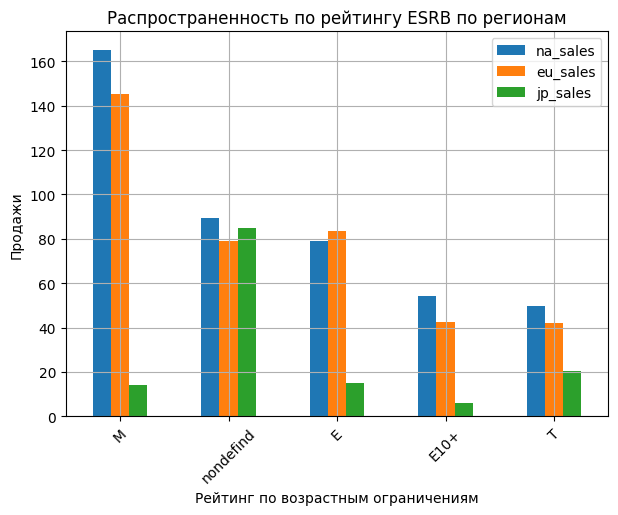

In [44]:
(df_actual.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().sort_values('na_sales', ascending=False)
# сгруппируем значения по рейтингу в зависимости от суммы продаж в каждом регионе
    .plot(kind='bar', rot=45, xlabel='Рейтинг по возрастным ограничениям', ylabel='Продажи', figsize=(7,5), grid=True), 
 plt.title('Распространенность по рейтингу ESRB по регионам')); # зададим название графика

- В Японии определяется наибольшее количество пропусков среди рейтинга ESRB, потому что система возрастных используется для США и Европы, в Японии своя система возрастных ограничений - CERO.   
- Рейтинг ESRB, который основан на возрастных ограничениях, вряд ли влияет на продажи, скорее количество игр, выпускаемых с определенными ограничениями (наибольшее количество игр идет для всех - для лиц 17+ (М), подростков (Т) и для каждого (Е everyone). По странам примерно одинаковое распределение: в Америке и Европе наибольшее количество игр продается для лиц 17+ (М) и среди категории everyone, Японию оценивать по таким данным нерелевантно.

# Проверка гипотез

## Сравнение средних пользовательских рейтингов платформ Xbox One и PC 

- H0: средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- H1: средние пользовательские рейтинги платформ Xbox One и PC различаются (двусторонняя гипотеза). 

Нулевая гипотеза всегда формируется со знаком равно, альтернативная - та, которая будет верна, если нулевая гипотеза не подтвердится. Чтобы это проверить, существуют различные тесты. В данном случае необходимо применять метод для двух независимых совокупностей, потому что скорее всего, пользователи разных платформ отличаются и не связаны между собой, учитывая разное количество участников и, возможно, разную дисперсию в выборках, необходимо указать аргумент equal_var = False.
    
Уровень критической значимости alpha установим 5%, он указывает на 5% риск сделать вывод о существовании различия, когда его на самом деле его нет. 

In [46]:
(df_actual.query('platform == "XOne" or platform == "PC"')
 .groupby('platform')['user_score'].agg(['count', 'mean'])) 
# сгруппируем значения по нужным платформам и посчитаем количество и средние значения оценок пользователей

,count,mean
platform,,
PC,149,75.550336
XOne,169,73.325444


На первый взгляд средние пользовательнские оценки мало отличаются, необходимо это проверить с помощью статистических тестов, тк у выборок могут быть разные разбросы, разное количество участников, тесты помогают подтвердить, является ли полученные различия статистически значимыми, а не случайными.  

In [47]:
platf_pc = df_actual.query('platform == "PC"')['user_score']
platf_xone = df_actual.query('platform == "XOne"')['user_score']

alpha = .05 # объявим критический уровень статистической значимости 5%
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    platf_pc, 
    platf_xone, nan_policy='omit', equal_var = False) 
# указываем значение False, тк выборки разного размера и/ можно предположить, что дисперсии у генеральных совокупностей разные
# nan_policy='omit' аргумент, который игнорирует NaN в совокупностях

print('p-значение:', results.pvalue) #выведим на экран получившеся p-значение

if results.pvalue < alpha: # сравним получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.09210180347405485
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось, следовательно, после проведения статистических тестов на сравнение двух разных совокупностей с неодинаковом количеством участников и, возможно, разной дисперсией, можно сделать вывод о том, что средние пользовательские рейтинги платформ PC и Xbox One одинаковые (6.269677 и 6.521429 соответственно). 

## Сравнение средних пользовательских рейтингов жанров Action и Sports.

- Н0: средние пользовательские рейтинги жанров Action и Sport одинаковые
- Н1: средние пользовательские рейтинги  различаются. 

В данном случае, аналогично с предыдущим, необходимо применять метод для двух независимых совокупностей, потому что мы не можем знать наверняка, совпадают ли участники двух выборок, скорее всего, разные пользователи предпочитают играть в свои любимые жанры и можно выделить тех, кто играет в боевики и тех, кто предпочитает спортивные игры. 

In [48]:
(df_actual.query('genre == "Action" or genre == "Sports"')
 .groupby('genre')['user_score'].agg(['count', 'mean'])) 
# сгруппируем значения по нужным жанрам и посчитаем количество и средние значения оценок пользователей

,count,mean
genre,,
Action,313,71.453674
Sports,112,71.660714


Группа, предпочитающая жанр боевик превышает более чем в два раза группу, предпочитающую спортивные игры, следвательно, при проведении стат. тестов необходимо указать аргумент equal_var = False.

In [49]:
action = df_actual.query('genre == "Action"')['user_score']
sports = df_actual.query('genre == "Sports"')['user_score']

alpha = .05 # объявим критический уровень статистической значимости 5%
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    action, 
    sports, nan_policy='omit', equal_var = False) 
# указываем значение False, тк выборки разного размера и/ можно предположить, что дисперсии у генеральных совокупностей разные
# nan_policy='omit' аргумент, который игнорирует NaN в совокупностях

print('p-значение:', results.pvalue) #выведим на экран получившеся p-значение

if results.pvalue < alpha: # сравним получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9022984279073378
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось, то есть средние пользовательские рейтинги жанров Action и Sport в наших выборках (6.837532 и 5.238125 соответственно) имеют достоверно значимое различие, как мы видим, средние показатели оценок пользователей, предпочитающих жанр боевик выше, чем средние оценки пользователей, предпочитающих жанр спортивных игр. 

# Выводы

Был проведен анализ данных по компьютерным играм для интернет-магазина за период с 1985 по 2016гг с целью 
выявления закономерностей, которые определяют успешность игры для определения потенциально популярного и прибыльного продукта. Данные содержали информацию о названии игры, год ее релиза, название платформы, количество проданных копий по регионам (Америка, Европа и Япония), жанр игры и ее рейтинг в зависимости от возрастных ограничений, оценки пользователей и критиков. 
Данные были обработаны, исправлены названия столбцов, пропущенные значения из столбцов с жанром игры и годом релиза были удалены (1.6%), пропуски в столбцах с оценкой пользователей и критиков были оставлены в датасете. 
Большое количество пропущенных значений в столбце с рейтингом (50% от датасета) объясняется тем, что рейтинг, используемый в данном датасете ESRB создан для использования в Америке и Европе, поэтому игры, выпускаемые в Японии, данные категории рейтинга не содержат (значения пропущены). 
При исследовательской части работы были сделаны следующие выводы:
- в целом популярность компьютерных игр интернет-магазина набирала рост начиная с 1999 (с появлением первых приставок и контроллеров, компьютерных игр онлайн) по 2007, с 2008г - определяется спад, связанный вероятнее всего с тем, что количество выпускаемых игр стало уменьшаться, сейчас наблюдается тренд на качество игр, их стали разрабатывать более детализировано, реалистично, соотвественно, времени на разработку игры уходит больше
- игровые приставки имеют срок жизни в 7-10 лет, начиная с ее выпуска с пиком популярности и ее снижением в связи с выпуском нового поколения, при этом отмечается, что при выпуске следующего поколения определенной консоли, игры на предыдущее поколения покупают еще 2-3 года
- для анализа был определен актуальный период с 2013 по 2016гг, который не содержит пиков по продажам популярных игровых приставок, но в то же время содержит достаточное количество данных для построения прогнозов
- отзывы пользователей на различные платформы никак не влияют на продажи, между отзывами критиков и продажами отмечается слабо положительная корреляция (40%)
- были выявлены наиболее популярные жанры за актуальный период по количеству игр: боевики, ролевые игры и спортивные
- наиболее прибыльными являются жанры: шутеры, спортивные игры, платформеры. Менее прибыльные - приключенческие игры, стратегии, пазлы
- были проанализированы продажи в Америке, Японии и Европе и определены топ 5 самых популярных и прибыльных жанров и игровых приставок:
- В Америке: platform, fighting, action, misc, adventure
- В Европе: platform, action, fighting, misc, adventure
- В Японии: fighting, misc, action
- Рейтинг по популярным приставкам в Америке по убыванию: X360, XOne, PS4, PS3, 3DS
- В Европе: X360, PS4, XOne, PS3, 3DS
- В Японии: 3DS, PS3, PS4
    
Для построения прогнозов необходимо учитывать несколько факторов: на какую аудиторию нацелена игра, более прибыльные жанры, которыми оказались на текущий момент - шутеры, спортивные игры, платформеры, срок жизни приставок, судя по тенденциям, актуальными на 2017г будут PS4 и XOne.   
    
Была подверждена гипотеза о средних показателей рейтинга пользователей платформ PC и Xbox One, они равны (6.269677 и 6.521429 соответственно) и опровергнута гипотеза о том, что средние показатели оценок пользователей, предпочитающих жанр боевик совпадают со  средними оценками пользователей, предпочитающих жанр спортивных игр.